# Ray RLlib Multi-Armed Bandits - Linear Thompson Sampling

© 2019-2021, Anyscale. All Rights Reserved

![Anyscale Academy](../../images/AnyscaleAcademyLogo.png)

This lesson uses a second exploration strategy we discussed briefly in lesson [02 Exploration vs. Exploitation Strategies](02-Exploration-vs-Exploitation-Strategies.ipynb), _Thompson Sampling_, with a linear variant, [LinTS](https://docs.ray.io/en/latest/rllib-algorithms.html?highlight=greedy#linear-thompson-sampling-contrib-lints).

## Wheel Bandit

We'll use it on the `Wheel Bandit` problem ([RLlib discrete.py source code](https://github.com/ray-project/ray/blob/master/rllib/contrib/bandits/envs/discrete.py)), which is an artificial problem designed to force exploration. It is described in the paper [Deep Bayesian Bandits Showdown](https://arxiv.org/abs/1802.09127) (see _The Wheel Bandit_ section). The paper uses it to  model 2D contexts, but it can be generalized to more than two dimensions.

You can visualize this problem as a wheel (circle) with four other regions around it. An exploration parameter delta $\delta$ defines a threshold, such that if the norm of the context vector is less than or equal to delta (inside the “wheel”) then the leader action is taken (conventionally numbered `1`). Otherwise, the other four actions are explored.

From figure 3 in [Deep Bayesian Bandits Showdown](https://arxiv.org/abs/1802.09127), the Wheel Bandit can be visualized this way:

![Wheel Bandit](../../images/rllib/Wheel-Bandit.png)

The radius of the entire colored circle is 1.0, while the radius of the blue "core" is $\delta$.

Contexts are sampled randomly within the unit circle (radius 1.0). The optimal action for the blue, red, green, black, or yellow region is the action 1, 2, 3, 4, or 5, respectively. In other words, if the context is in the blue region, radius < $\delta$, action 1 is optimal, if it is in the upper-right-hand quadrant with radius between $\delta$ and 1.0, then action 2 is optimal, etc.

The parameter $\delta$ controls how aggressively we explore. The reward $r$ for each action and context combination are based on a normal distribution as follows:

Action 1 offers the reward, $r \sim \mathcal{N}({\mu_1,\sigma^2})$, independent of context.

Actions 2-5 offer the reward, $r \sim \mathcal{N}({\mu_2,\sigma^2})$ where $\mu_2 < \mu_1$, _when they are suboptimal choices_. When they are optimal, the reward is $r \sim \mathcal{N}({\mu_3,\sigma^2})$ where $\mu_3 \gg \mu_1$.

In addition to $\delta$, the parameters $\mu_1$, $\mu_2$ $\mu_3$, and $\sigma$ are configurable. The default values for these parameters in the paper and in the [RLlib implementation](https://github.com/ray-project/ray/blob/master/rllib/contrib/bandits/envs/discrete.py) are as follows:

```python
DEFAULT_CONFIG_WHEEL = {
    "delta": 0.5,
    "mu_1": 1.2,
    "mu_2": 1.0,
    "mu_3": 50.0,
    "std": 0.01  # sigma
}
```

Note that the probability of a context randomly falling in the high-reward region (not blue) is 1 − $\delta^2$. Therefore, the difficulty of the problem increases with $\delta$, and algorithms used with this bandit are more likely to get stuck repeatedly selecting action 1 for large $\delta$.

## Use Wheel Bandit with Thompson Sampling

Note the import in the next cell of `LinTSTrainer` and how it is used below when setting up the _Tune_ job. For the `LinUCB` example in the [previous lesson](04-Linear-Upper-Confidence-bound.ipynb), we didn't import the corresponding `LinUCBTrainer`, but passed a "magic" string to Tune, `contrib/LinUCB`, which RLlib already knows how to associate with the corresponding `LinUCBTrainer` implementation. Passing the class explicitly, as we do here, is an alternative. The [RLlib environments documentation](https://docs.ray.io/en/latest/rllib-env.html) discusses these techniques.

In [5]:
import time
import numpy as np
import pandas as pd
import ray
from ray.rllib.contrib.bandits.agents import LinTSTrainer
from ray.rllib.contrib.bandits.agents.lin_ts import TS_CONFIG
from ray.rllib.contrib.bandits.envs import WheelBanditEnv

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
wbe = WheelBanditEnv()
wbe.config

{'delta': 0.5, 'mu_1': 1.2, 'mu_2': 1, 'mu_3': 50, 'std': 0.01}

The effective number of `training_iterations` will be `20 * timesteps_per_iteration == 2,000` where the timesteps per iteration is `100` by default.

In [8]:
TS_CONFIG["env"] = WheelBanditEnv

training_iterations = 20
print("Running training for %s time steps" % training_iterations)

Running training for 20 time steps


What's in the standard config object for _LinTS_ anyway??

In [9]:
TS_CONFIG

{'num_workers': 0,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 1,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 1,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'num_framestacks': 'auto',
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist

Initialize Ray...

In [10]:
ray.init(ignore_reinit_error=True)

2021-05-22 13:30:50,283	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.156',
 'raylet_ip_address': '192.168.1.156',
 'redis_address': '192.168.1.156:6379',
 'object_store_address': '/tmp/ray/session_2021-05-22_13-30-49_767763_30692/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-22_13-30-49_767763_30692/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-22_13-30-49_767763_30692',
 'metrics_export_port': 61234,
 'node_id': '7d1f994385e9e0c6c9bcfd7988132668597230eedf8b7da2fd080ebd'}

In [13]:
analysis = ray.tune.run(
    LinTSTrainer,
    config=TS_CONFIG,
    stop={"training_iteration": training_iterations},
    num_samples=2,
    checkpoint_at_end=True,
    verbose=1
)

2021-05-22 13:31:05,144	INFO tune.py:450 -- Total run time: 4.60 seconds (4.29 seconds for the tuning loop).


How long did it take?

In [14]:
stats = analysis.stats()
secs = stats["timestamp"] - stats["start_time"]
print(f'{secs:7.2f} seconds, {secs/60.0:7.2f} minutes')

   4.29 seconds,    0.07 minutes


Analyze cumulative regrets of the trials

In [15]:
df = pd.DataFrame()

for key, df_trial in analysis.trial_dataframes.items():
    df = df.append(df_trial, ignore_index=True)

regrets = df \
    .groupby("info/num_steps_trained")["info/learner/default_policy/cumulative_regret"] \
    .aggregate(["mean", "max", "min", "std"])

regrets

,mean,max,min,std
info/num_steps_trained,,,,
100,2012.934657,2111.142077,1914.727236,138.886266
200,3757.799133,3928.316339,3587.281926,241.147747
300,5575.537827,5647.915735,5503.159919,102.357819
400,7393.347944,7709.368085,7077.327804,446.919969
500,8941.911893,9282.711536,8601.112250,481.963478
600,10343.186242,11002.852180,9683.520304,932.908516
700,11646.593932,12429.244236,10863.943628,1106.834674
800,12582.377369,13218.902941,11945.851797,900.183097
900,13714.240652,14448.649999,12979.831306,1038.611658


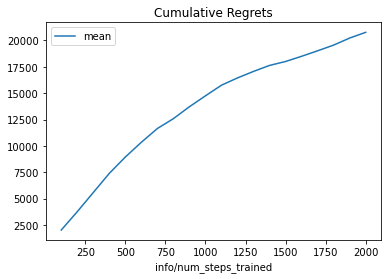

In [16]:
regrets.plot(y="mean", title="Cumulative Regrets")

As always, here is an [image](../../images/rllib/LinTS-Cumulative-Regret-05.png) from a previous run. How similar is your graph? We have observed a great deal of variability from one run to the next, more than we have seen with _LinUCB_. This suggests that extra caution is required when using _LinTS_ to ensure that good results are achieved.

Here is how you can restore a trainer from a checkpoint:

In [17]:
trial = analysis.trials[0]
trainer = LinTSTrainer(config=TS_CONFIG)
trainer.restore(trial.checkpoint.value)

2021-05-22 13:31:17,001	INFO trainer.py:641 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'vec' in call to _th_mv

Get model to plot arm weights distribution

In [18]:
model = trainer.get_policy().model
means = [model.arms[i].theta.numpy() for i in range(5)]
covs = [model.arms[i].covariance.numpy() for i in range(5)]
model, means, covs

NameError: name 'trainer' is not defined

Plot the weight distributions for the different arms:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

colors  = ["blue", "black", "green", "red", "yellow"]
labels  = ["arm{}".format(i) for i in range(5)]

for i in range(0, 5):
    x, y = np.random.multivariate_normal(means[i] / 30, covs[i], 5000).T
    plt.scatter(x, y, color=colors[i])
    
plt.show()

Here's an [image](../../images/rllib/LinTS-Weight-Distribution-of-Arms-05.png) from a previous run. How similar is your graph?

## Exercise 1

Experiment with different $\delta$ values, for example 0.7 and 0.9. What do the cumulative regret and weights graphs look like? 

You can set the $\delta$ value like this:

```python
TS_CONFIG["delta"] = 0.7
```

See the [solutions notebook](solutions/Multi-Armed-Bandits-Solutions.ipynb) for discussion of this exercise.

In [ ]:
ray.shutdown()